In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform, get_transform
# from project.preprocessing import z_score_normalization, min_max_normalization
# from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array, collatev2, compute_statistics
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer, ISAVIT
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.feeder import Feeder
import seaborn as sns
from project.evaluation import isa_vit_metric

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('andy')
fh = logging.FileHandler(f'logs/{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_10_2024_232214'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Config for fitter

In [4]:
image_size = 300
patch_size = 16

config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.0001
}

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Create Stage 1 Network

In [5]:
from project.model import Feeder, RPN, GCRPN

resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)
rpn = RPN(
    input_dim=512,
    output_dim=4,
    image_size=image_size,
    nh=4
)

stone = GCRPN(
    rpn=rpn,
    feeder=feeder,
    image_size=image_size,
    patch_size=patch_size
)

324


In [6]:
stone.rpn.load_state_dict(torch.load('RPN_test15_weights_Nov_02_2024_192506.pt'))

<All keys matched successfully>

#### Load ViT Weights

### Load dataset

In [7]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [8]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1,1,928.405273
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1,1,928.405273
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1,1,928.405273
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1,1,928.405273
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1,1,928.405273
...,...,...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,241.000000
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1,3,241.000000
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1,3,448.000000
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,448.000000


### `DataLoader` Generator

In [9]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [10]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader

### Fitter

In [11]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss = self.train_one_epoch(train_loader, stage1)
            val_loss = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
        return train_history, val_history

    def train_one_epoch(self, train_loader, stage1):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'accuracy_score': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float()
                masks = masks.float()

                with torch.inference_mode():
                    x, t = stage1(slices, masks, target)
                
                # self.log(f'{x.requires_grad}, {t.requires_grad}')
                # self.log(f'{x.shape}, {t.shape}')

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)

                dice_score, precision_score, recall_score, accuracy_score = isa_vit_metric(y.sigmoid().squeeze().detach().cpu().numpy(), t[target].squeeze().detach().cpu().numpy())
                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['accuracy_score'].append(accuracy_score)

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f'Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}')
        self.log(f'Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}')
        self.log(f'Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}')
        self.log(f'Avg Accuracy: {sum(evaluation_metric['accuracy_score']) / len(evaluation_metric['accuracy_score'])}')
        return loss_history, evaluation_metric
    
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'accuracy_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float()
                    masks = masks.float()
                    x, t = stage1(slices, masks, target)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, accuracy_score = isa_vit_metric(y.sigmoid().squeeze().detach().cpu().numpy(), t[target].squeeze().detach().cpu().numpy())
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['accuracy_score'].append(accuracy_score)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f'Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}')
        self.log(f'Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}')
        self.log(f'Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}')
        self.log(f'Avg Accuracy: {sum(evaluation_metric['accuracy_score']) / len(evaluation_metric['accuracy_score'])}')
        return loss_history, evaluation_metric

In [12]:
fitter = ViTFitter(config, logger=logger)

### Training

In [13]:
tl, vl = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False,
    batch_size=20
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 7), (9, 7))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [14]:
thist, vhist, tmhist, vmhist = fitter.fit(tl, vl, stone)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Error processing: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

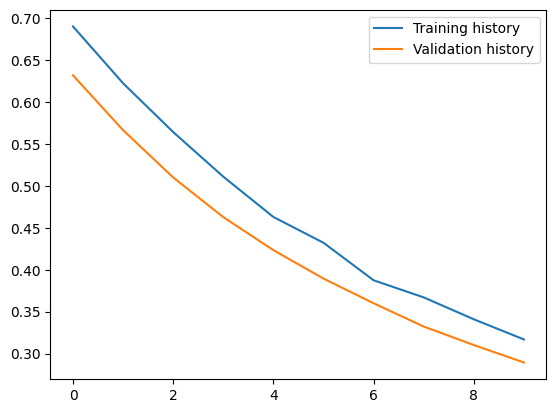

In [ ]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

### Trial

In [ ]:
sample = next(enumerate(tl))

In [ ]:
case = sample[1][0]

In [ ]:
slices, masks, target, path = case

<Axes: >

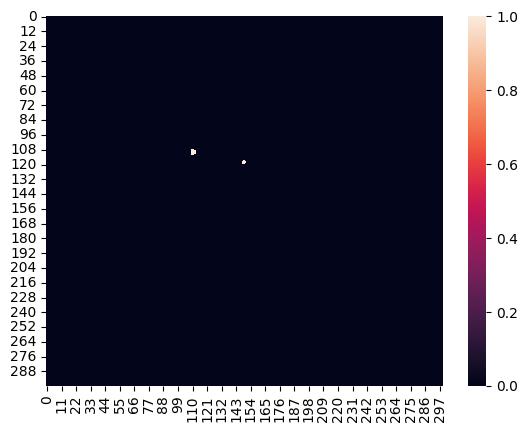

In [ ]:
sns.heatmap(masks[target].squeeze())

In [ ]:
slices = slices.squeeze(1).float()
masks = masks.float()

In [ ]:
x, t = stone(slices, masks, target)

<Axes: title={'center': 'Mask Slice Crop'}>

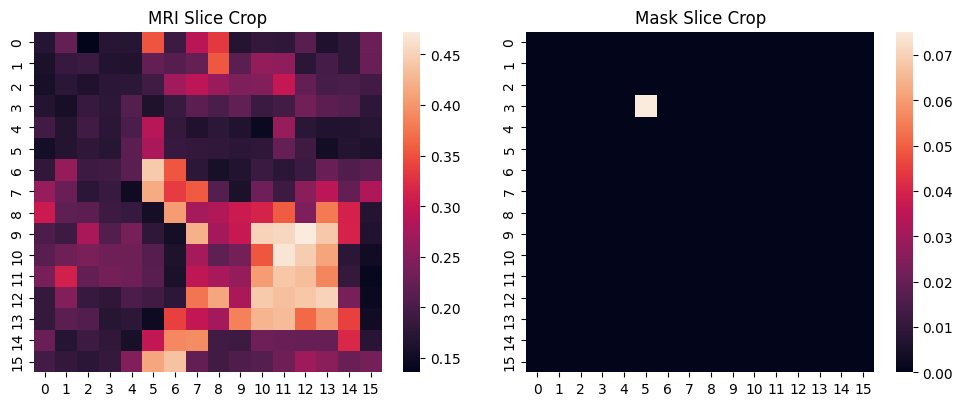

In [ ]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
sns.heatmap(x[target].squeeze(), ax=ax1)
sns.heatmap(t[target].squeeze(), ax=ax2)

In [ ]:
vit = config['model']

In [ ]:
x.shape

torch.Size([35, 1, 16, 16])

In [ ]:
y = vit(x.flatten(2).to(device), target)

In [ ]:
y = y.view(patch_size, patch_size)

<Axes: title={'center': 'Mask Truth'}>

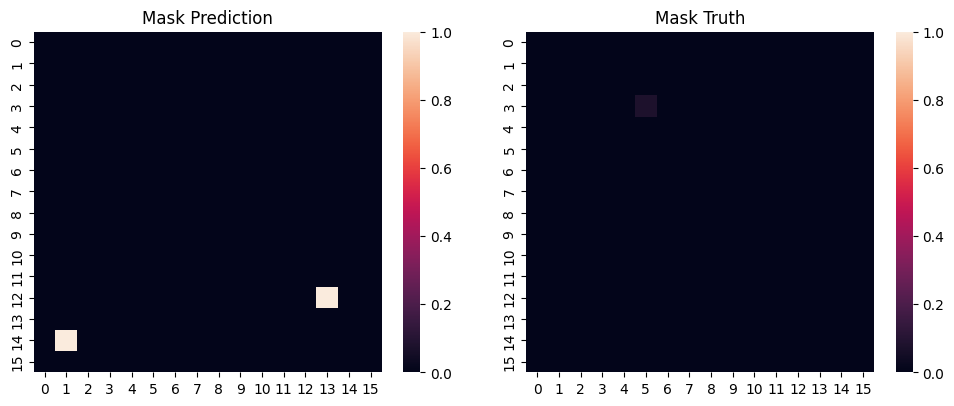

In [ ]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
sns.heatmap((y > -0.3).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(t[target].squeeze(), ax=ax2, vmax=1)

In [ ]:
import datetime

s = f'vit_weights_{datetime.datetime.now().strftime("%d%m%y%H%M%S")}.pt'
model = config['model']
torch.save(model.state_dict(), s)